In [1]:
import psycopg2 as pg2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')


In [97]:

conn = pg2.connect(user='postgres',  dbname='scrabble', host='localhost', port='5432', password='myPassword')
cur = conn.cursor()

sql = """SELECT * from turn where 
gamenum NOT IN (SELECT gamenum from game where p1_final_score > 800 or p1_final_score < 150) AND
gamenum NOT IN (SELECT gamenum from game where p2_final_score > 800 or p2_final_score < 150)

and challenged_away = FALSE and is_challenge=FALSE
and is_exchange=FALSE"""

df = pd.read_sql(sql ,con=conn)
df_games = pd.read_sql("SELECT * from game", con=conn)


#df = df[df["move"].apply(lambda x: not x.startswith('-chl-'))]
#df = df[df["move"].apply(lambda x: x != '---')]
df["move"] = df["move"].apply(lambda x: x.replace('.', ''))
df["movelen"] = df["move"].apply(lambda x: len(x))
print(df.shape)
df_by_game = df.groupby(df["gamenum"]).sum()
df = df[df.gamenum.isin(df_by_game[(df_by_game.movelen <= 100) & (df_by_game.movelen >= 93)].index)]
print (df.shape)

(755464, 17)
(745372, 17)


In [100]:
df_all_letters = df.groupby(['gamenum','is_player2'])['move'].apply(''.join).reset_index()

def find_blanks(s):
    return "".join(sorted([l if l.isupper() else '?' for l in s]))

df_all_letters["letters_cleaned"] = df_all_letters['move'].apply(find_blanks)

In [101]:
df_all_letters

,gamenum,is_player2,move,letters_cleaned
0,1,0,AYGURUQIPOISOJAWAREDEMOIGDIFDILAIONONETROLLERM...,AAAAADDDEEEEEFGGHIIIIIIJLLLMMNNOOOOOOOPQRRRRST...
1,1,1,HEARTVEXUNSINTENSEAZETURBTTWICPALSYBCKmODIFiENAG,??AAAABBCCDEEEEEEFGHIIIKLNNNNOPRRSSSTTTTTUUVWXYZ
2,8,0,FICOSOLATINXBAARURGOREHOPHIEFAMDENUTGIEZONeNUT,?AAAABCDEEEEFFGGHHIIIILMNNNNOOOOOPRRRSTTTUUUXZ
3,8,1,JAdEATIONDILYCIGOMALAYESQUAREVEEPSNERVEBLWDKTI...,?AAAAABCDDDEEEEEEEEGIIIIJKLLLMNNOOOPQRRRSSTTTU...
4,9,0,TRUKCOZGALAVIWYImPLIESFRUTIERNAFLANINGSQUAWJOH...,??AAAAABCDEEFFGGHIIIIIIJKLLLMNNNOOOOPQRRRSSTTU...
...,...,...,...,...
59949,34533,1,NUBOUPASAECLOTEFTUIJOTQIHONVUGWYNPECTeRS,?AABCCEEEFGHIIJLNNNOOOOPPQRSSTTTTUUUUVWY
59950,34534,0,IRONYJTOIENTERVOMRCHWEDWHELKSAXVULBEADEOPRIZ,AABCDDEEEEEEHHIIIJKLLMNNOOOOPRRRRSTTUVVWWXYZ
59951,34534,1,TUNELeDADOOIGAMBIUNTQUAtINGAORTICINEFLEASPAISA...,??AAAAAAABCDDEEEEFFGGGIIIIIILLMNNNNOOOOPQRRSSS...
59952,34535,0,AEFUDDOCKEDHUEZROESRANQINGRAFTGMBmYLONITOWGIRO...,?AAABCDDDEEEEEFFGGGHIIIIKLLMMNNNOOOOOPQRRRRSTT...


In [102]:
p2_scores = df_all_letters[df_all_letters.is_player2==" 1"].merge(df_games, left_on="gamenum", right_on="gamenum")

p1_scores = df_all_letters[df_all_letters.is_player2==" 0"].merge(df_games, left_on="gamenum", right_on="gamenum")

In [57]:
p1_scores[p1_scores.p1_final_score < 150]

,gamenum,is_player2,move,letters_cleaned,p1_id,p1_name,p2_id,p2_name,lexicon,p1_final_score,p2_final_score


In [66]:
np.mean(p1_scores[p1_scores.letters_cleaned.apply(lambda x:"EEEEEEEEEEE" in x)]["p1_final_score"])

462.6265060240964

In [70]:
p1_scores  #[p1_scores.letters_cleaned.apply(lambda x:"??" in x)]

,gamenum,is_player2,move,letters_cleaned,p1_id,p1_name,p2_id,p2_name,lexicon,p1_final_score,p2_final_score
0,1,0,AYGURUQIPOISOJAWAREDEMOIGDIFDILAIONONETROLLERM...,AAAAADDDEEEEEFGGHIIIIIIJLLLMMNNOOOOOOOPQRRRRST...,500,John O'Laughlin,10122,Seth Lipkin,TWL06,442.0,424.0
1,8,0,FICOSOLATINXBAARURGOREHOPHIEFAMDENUTGIEZONeNUT,?AAAABCDEEEEFFGGHHIIIILMNNNNOOOOOPRRRSTTTUUUXZ,10122,Seth Lipkin,66,Joel Horn,TWL06,316.0,366.0
2,9,0,TRUKCOZGALAVIWYImPLIESFRUTIERNAFLANINGSQUAWJOH...,??AAAAABCDEEFFGGHIIIIIIJKLLLMNNNOOOOPQRRRSSTTU...,590,Debbie Stegman,10122,Seth Lipkin,TWL06,476.0,333.0
3,10,0,INSETTEVGILGEEFEYJOFULNOSTRIlINKRAXDEAVAWARHLO...,?AAAAABDEEEEEEEEFFGGHIIIIJKLLLNNNOOOOORRRSSTTT...,1954,Kate Fukawa-Connelly,1787,Dielle Saldanha,TWL06,395.0,351.0
4,11,0,COALYREODoNTEENSIERWAIVOBIAHUMANEPOMRAWINAXFEY...,?AAAAAAABCDDEEEEEEFHIIIIILMMNNNNOOOOPRRRRSTTTU...,10122,Seth Lipkin,1598,Ben Dweck,TWL06,430.0,434.0
...,...,...,...,...,...,...,...,...,...,...,...
29988,34531,0,APOTROPARYNOAUGRAZIeRFIBROSEHAEMELEETOADCIMVIS...,?AAAAAAABCDDEEEEEFGGHIIIIIILLMMNNOOOOOOPPQRRRR...,20411,jvc,564,Terry,CSW19,502.0,328.0
29989,34532,0,COOKWEBZPJOINTDHSUQRIDNUHAIAINGrATEDREWNET,?AAABCDDDEEEEGHHIIIIJKNNNNOOOPQRRSTTTUUWWZ,564,Terry,20411,jvc,CSW19,364.0,485.0
29990,34533,0,BAONHYEDORMDISLEAFGREIZESDARRINEMIgRAONGWKEODA...,?AAAAAAABDDDDEEEEEEEEFGGHIIIIIIKLMMNNNOOOORRRR...,18086,Matt,20411,jvc,CSW19,526.0,343.0
29991,34534,0,IRONYJTOIENTERVOMRCHWEDWHELKSAXVULBEADEOPRIZ,AABCDDEEEEEEHHIIIJKLLMNNOOOOPRRRRSTTUVVWWXYZ,20032,jackson,17589,joey,NSW18,348.0,378.0


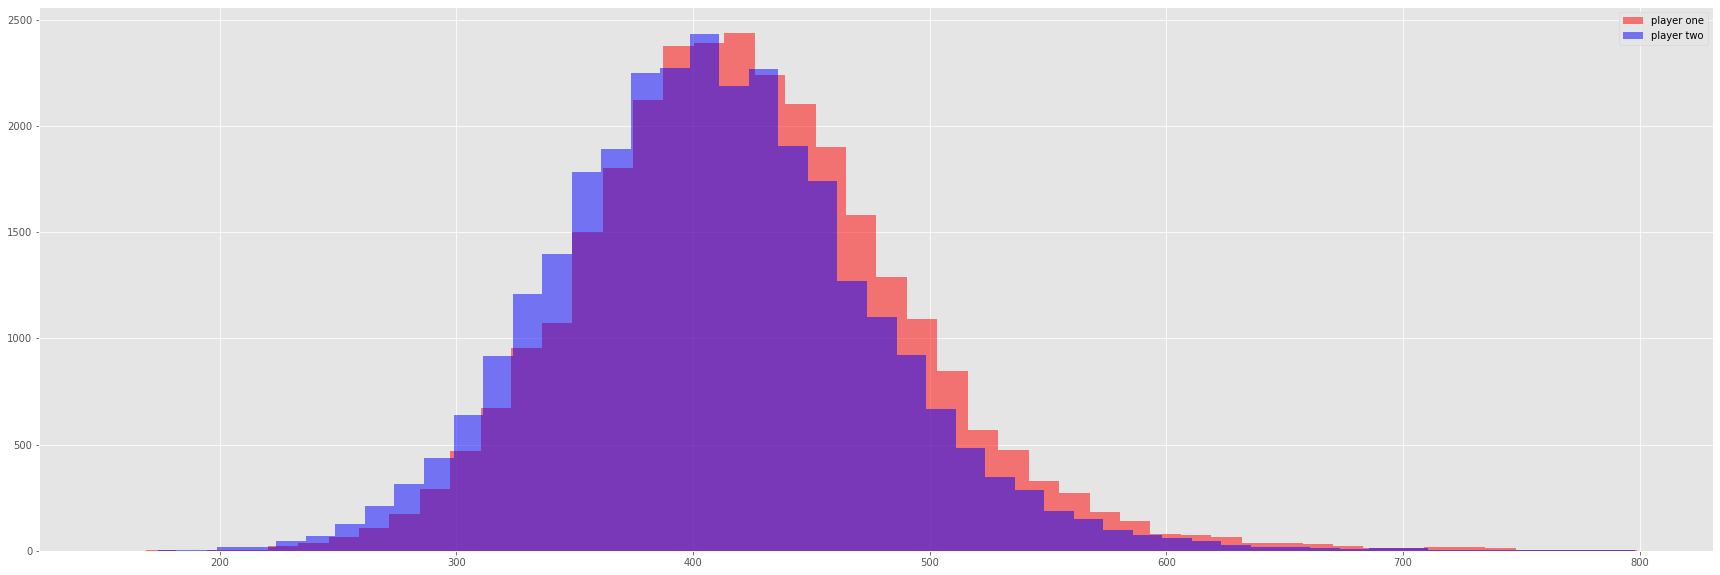

In [109]:
fig, ax = plt.subplots(figsize=(30,10))
ax.hist([p1_scores.p1_final_score], bins=50, alpha=0.5, color="red", label="player one")
ax.hist(p2_scores.p2_final_score, bins=50, alpha=0.5, color="blue", label="player two")
ax.legend()

(array([2.0600e+02, 3.7140e+03, 1.3028e+04, 1.0426e+04, 2.2360e+03,
        2.9500e+02, 6.2000e+01, 1.6000e+01, 8.0000e+00, 2.0000e+00]),
 array([174., 255., 336., 417., 498., 579., 660., 741., 822., 903., 984.]),
 <a list of 10 Patch objects>)

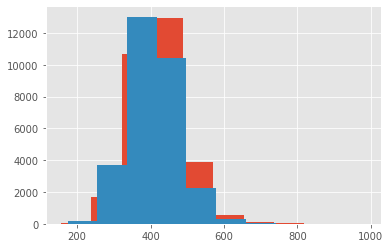